## Multiple case comparison

## Packages

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle
import seaborn as sns

import nygrid.run_nygrid as ng_run
import nygrid.nygrid as ng_grid
import nygrid.postprocessing as ng_post

In [5]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

In [6]:
# Cost modifiers
ext_cost_factor = 0.0
# fo_cost_factor = 1.0
fo_cost_factor = 0.5

# Simulation time settings
valid_days = 14
lookahead_days = 2

valid_hours = 24 * valid_days
lookahead_hours = 24 * lookahead_days

sim_start_time = datetime(2018, 1, 1, 0, 0, 0)
sim_end_time = datetime(2018, 12, 31, 23, 0, 0)
timestamp_list = pd.date_range(
    sim_start_time, sim_end_time, freq=f'{valid_days}D')

In [27]:
gen_fuel_rename = {
    'NU_UR': 'Nuclear',
    'CC_NG': 'Combined Cycle (NG)',
    'ST_BIT': 'Steam Turbine (BIT)', 
    'ST_FO6': 'Steam Turbine (FO6)',
    'ST_NG': 'Steam Turbine (NG)',
    'CT_FO2': 'Combustion Turbine (FO2)',
    'CT_KER': 'Combustion Turbine (KER)',
    'CT_NG': 'Combustion Turbine (NG)',
    'Other_Other': 'Other',
    'Import_Import': 'Import (or Export)',
    'DCLine_F': 'DC Line (From)',
    'DCLine_T': 'DC Line (To)',
    'HY_WAT': 'Hydro',
    'PSH': 'Pumped Hydro Storage',
    'PV_SUN': 'Utility-scale PV',
    'LBW': 'Land-based Wind',
    'OSW': 'Offshore Wind',
    'BES': 'Battery Storage',
}

# Pumped hydro storage units
phs_names = [
    'Gilboa 1 (IIFO - 1/1/2019)', 'Gilboa 2', 
    'Gilboa 3', 'Gilboa 4', 'Lewiston PS'
]

# Offshore wind units
osw_names = [
    'Attentive Energy', 'Beacon Wind', 
    'Community Offshore Wind', 'Empire Offshore Wind',
    'Mid-Atlantic Offshore Wind', 'Sunrise Wind'
]

zone_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
              'NE', 'PJM', 'IESO', 'HQ']

## Read OPF results

### A. 2018NewParams

In [7]:
sim_name_2018NewParams = f'2018NewParams_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir = os.path.join(data_dir, 'grid', '2018NewParams')
assert os.path.exists(
    grid_data_dir), f'Grid data directory not found: {grid_data_dir}'

sim_results_dir = os.path.join(results_dir, sim_name_2018NewParams)
assert os.path.exists(
    sim_results_dir), f'Results directory not found: {sim_results_dir}'

# Read load and generation profiles
grid_prop_2018NewParams = ng_run.read_grid_prop(grid_data_dir)
display(grid_prop_2018NewParams.keys())

grid_profile_2018NewParams = ng_run.read_grid_profile(grid_data_dir, year=2018)
display(grid_profile_2018NewParams.keys())

# Generator fuel types
display(grid_prop_2018NewParams['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2018NewParams = ng_grid.NYGrid(grid_prop=grid_prop_2018NewParams,
                            start_datetime=start_datetime_0,
                            end_datetime=end_datetime_0,
                            verbose=False)
print(f"Number of generators: {nygrid_sim_2018NewParams.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2018NewParams.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2018NewParams.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2018NewParams.NESR}")
print(f"Number of buses and branches: {nygrid_sim_2018NewParams.NB} and {nygrid_sim_2018NewParams.NBR}")
print(f"Number of loads: {nygrid_sim_2018NewParams.NL}")
print(f"Number of time periods: {nygrid_sim_2018NewParams.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_FO6', 'ST_BIT',
       'NU_UR', 'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN',
       'Other_Other'], dtype=object)

Number of generators: 323
Number of HVDC lines: 5
Number of VRE generators: 0
Number of ESR units: 5
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [8]:
# Loop through all days
results_list_2018NewParams = []

for d in range(len(timestamp_list)):

    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2018NewParams}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2018NewParams.append(results)

In [9]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2018NewParams = ng_post.get_pg_by_fuel_from_list(results_list_2018NewParams,
                                                   nygrid_sim_2018NewParams,
                                                   valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2018NewParams = ng_post.get_esr_results_from_list(results_list_2018NewParams,
                                                nygrid_sim_2018NewParams,
                                                valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2018NewParams = ng_post.get_lmp_results_from_list(results_list_2018NewParams,
#                                                      nygrid_sim_2018NewParams,
#                                                      valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2018NewParams = ng_post.get_flow_results_from_list(results_list_2018NewParams,
                                                  nygrid_sim_2018NewParams,
                                                  valid_hours=valid_hours)

# Costs
cost_results_2018NewParams = ng_post.get_cost_results_from_list(results_list_2018NewParams,
                                                  nygrid_sim_2018NewParams,
                                                  valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2018NewParams = ng_post.get_slack_results_from_list(results_list_2018NewParams,
                                                    nygrid_sim_2018NewParams,
                                                    valid_hours=valid_hours)

In [24]:
# Separate PSH and ESR units
pg_by_fuel_dict_2018NewParams['PSH'] = pg_by_fuel_dict_2018NewParams['ESR'][phs_names].copy()

pg_by_fuel_dict_2018NewParams['BES'] = pg_by_fuel_dict_2018NewParams['ESR'].copy()
pg_by_fuel_dict_2018NewParams['BES'] = pg_by_fuel_dict_2018NewParams['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
# This scenario does not have OSW units
pg_by_fuel_dict_2018NewParams['LBW'] = pg_by_fuel_dict_2018NewParams['WT_WND'].copy()
pg_by_fuel_dict_2018NewParams['OSW'] = pg_by_fuel_dict_2018NewParams['WT_WND'].copy()
pg_by_fuel_dict_2018NewParams['OSW'] = pg_by_fuel_dict_2018NewParams['OSW'].drop(columns=pg_by_fuel_dict_2018NewParams['LBW'].columns)

### B. 2030BaselineCase

In [10]:
sim_name_2030BaselineCase = f'2030BaselineCase_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030BaselineCase')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030BaselineCase)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030BaselineCase = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030BaselineCase.csv',
                                       esr_prop_file='esr_prop_2030BaselineCase.csv',
                                       dcline_prop_file='dcline_prop_2030BaselineCase.csv')
display(grid_prop_2030BaselineCase.keys())

grid_profile_2030BaselineCase = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030BaselineCase.keys())

# Generator fuel types
display(grid_prop_2030BaselineCase['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030BaselineCase = ng_grid.NYGrid(grid_prop=grid_prop_2030BaselineCase,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030BaselineCase.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030BaselineCase.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030BaselineCase.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030BaselineCase.NESR}")
print(f"Number of buses and branches: {nygrid_sim_2030BaselineCase.NB} and {nygrid_sim_2030BaselineCase.NBR}")
print(f"Number of loads: {nygrid_sim_2030BaselineCase.NL}")
print(f"Number of time periods: {nygrid_sim_2030BaselineCase.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'ST_FO6', 'CT_KER', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 372
Number of HVDC lines: 5
Number of VRE generators: 0
Number of ESR units: 14
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [11]:
# Loop through all days
results_list_2030BaselineCase = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030BaselineCase}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030BaselineCase.append(results)

In [12]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030BaselineCase = ng_post.get_pg_by_fuel_from_list(results_list_2030BaselineCase, 
                                                        nygrid_sim_2030BaselineCase,
                                                        valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030BaselineCase = ng_post.get_esr_results_from_list(results_list_2030BaselineCase, 
                                                     nygrid_sim_2030BaselineCase,
                                                     valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030BaselineCase = ng_post.get_lmp_results_from_list(results_list_2030BaselineCase, 
#                                                      nygrid_sim_2030BaselineCase,
#                                                      valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030BaselineCase = ng_post.get_flow_results_from_list(results_list_2030BaselineCase, 
                                                       nygrid_sim_2030BaselineCase,
                                                       valid_hours=valid_hours)

# Costs
cost_results_2030BaselineCase = ng_post.get_cost_results_from_list(results_list_2030BaselineCase, 
                                                       nygrid_sim_2030BaselineCase,
                                                       valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030BaselineCase = ng_post.get_slack_results_from_list(results_list_2030BaselineCase, 
                                                         nygrid_sim_2030BaselineCase,
                                                         valid_hours=valid_hours)

In [23]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030BaselineCase['PSH'] = pg_by_fuel_dict_2030BaselineCase['ESR'][phs_names].copy()

pg_by_fuel_dict_2030BaselineCase['BES'] = pg_by_fuel_dict_2030BaselineCase['ESR'].copy()
pg_by_fuel_dict_2030BaselineCase['BES'] = pg_by_fuel_dict_2030BaselineCase['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
# This scenario does not have OSW units
pg_by_fuel_dict_2030BaselineCase['LBW'] = pg_by_fuel_dict_2030BaselineCase['WT_WND'].copy()
pg_by_fuel_dict_2030BaselineCase['OSW'] = pg_by_fuel_dict_2030BaselineCase['WT_WND'].copy()
pg_by_fuel_dict_2030BaselineCase['OSW'] = pg_by_fuel_dict_2030BaselineCase['OSW'].drop(columns=pg_by_fuel_dict_2030BaselineCase['LBW'].columns)

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030BaselineCase['ST_BIT'] = pg_by_fuel_dict_2030BaselineCase['CC_NG'].drop(columns=pg_by_fuel_dict_2030BaselineCase['CC_NG'].columns)

### C. 2030ContractCase

In [13]:
sim_name_2030ContractCase = f'2030ContractCase_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030ContractCase')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030ContractCase)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030ContractCase = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030ContractCase.csv',
                                       esr_prop_file='esr_prop_2030ContractCase.csv',
                                       dcline_prop_file='dcline_prop_2030ContractCase.csv')
display(grid_prop_2030ContractCase.keys())

grid_profile_2030ContractCase = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030ContractCase.keys())

# Generator fuel types
display(grid_prop_2030ContractCase['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030ContractCase = ng_grid.NYGrid(grid_prop=grid_prop_2030ContractCase,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030ContractCase.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030ContractCase.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030ContractCase.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030ContractCase.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030ContractCase.NB} and {nygrid_sim_2030ContractCase.NBR}")
print(f"Number of loads: {nygrid_sim_2030ContractCase.NL}")
print(f"Number of time periods: {nygrid_sim_2030ContractCase.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'ST_FO6', 'CT_KER', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 470
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 27
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [14]:
# Loop through all days
results_list_2030ContractCase = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030ContractCase}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030ContractCase.append(results)

In [15]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030ContractCase = ng_post.get_pg_by_fuel_from_list(results_list_2030ContractCase, 
                                                        nygrid_sim_2030ContractCase,
                                                        valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030ContractCase = ng_post.get_esr_results_from_list(results_list_2030ContractCase, 
                                                     nygrid_sim_2030ContractCase,
                                                     valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030ContractCase = ng_post.get_lmp_results_from_list(results_list_2030ContractCase, 
#                                                      nygrid_sim_2030ContractCase,
#                                                      valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030ContractCase = ng_post.get_flow_results_from_list(results_list_2030ContractCase, 
                                                       nygrid_sim_2030ContractCase,
                                                       valid_hours=valid_hours)

# Costs
cost_results_2030ContractCase = ng_post.get_cost_results_from_list(results_list_2030ContractCase, 
                                                       nygrid_sim_2030ContractCase,
                                                       valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030ContractCase = ng_post.get_slack_results_from_list(results_list_2030ContractCase, 
                                                         nygrid_sim_2030ContractCase,
                                                         valid_hours=valid_hours)

In [22]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030ContractCase['PSH'] = pg_by_fuel_dict_2030ContractCase['ESR'][phs_names].copy()

pg_by_fuel_dict_2030ContractCase['BES'] = pg_by_fuel_dict_2030ContractCase['ESR'].copy()
pg_by_fuel_dict_2030ContractCase['BES'] = pg_by_fuel_dict_2030ContractCase['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030ContractCase['LBW'] = pg_by_fuel_dict_2030ContractCase['WT_WND'].copy()
pg_by_fuel_dict_2030ContractCase['LBW'] = pg_by_fuel_dict_2030ContractCase['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030ContractCase['OSW'] = pg_by_fuel_dict_2030ContractCase['WT_WND'].copy()
pg_by_fuel_dict_2030ContractCase['OSW'] = pg_by_fuel_dict_2030ContractCase['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030ContractCase['ST_BIT'] = pg_by_fuel_dict_2030ContractCase['CC_NG'].drop(columns=pg_by_fuel_dict_2030ContractCase['CC_NG'].columns)


### D. 2030StateScenario

In [16]:
sim_name_2030StateScenario = f'2030StateScenario_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030StateScenario')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030StateScenario)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030StateScenario = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030StateScenario.csv',
                                       esr_prop_file='esr_prop_2030StateScenario.csv',
                                       dcline_prop_file='dcline_prop_2030StateScenario.csv')
display(grid_prop_2030StateScenario.keys())

grid_profile_2030StateScenario = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030StateScenario.keys())

# Generator fuel types
display(grid_prop_2030StateScenario['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030StateScenario = ng_grid.NYGrid(grid_prop=grid_prop_2030StateScenario,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030StateScenario.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030StateScenario.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030StateScenario.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030StateScenario.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030StateScenario.NB} and {nygrid_sim_2030StateScenario.NBR}")
print(f"Number of loads: {nygrid_sim_2030StateScenario.NL}")
print(f"Number of time periods: {nygrid_sim_2030StateScenario.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 471
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 40
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [17]:
# Loop through all days
results_list_2030StateScenario = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030StateScenario}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030StateScenario.append(results)

In [18]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030StateScenario = ng_post.get_pg_by_fuel_from_list(results_list_2030StateScenario, 
                                                        nygrid_sim_2030StateScenario,
                                                        valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030StateScenario = ng_post.get_esr_results_from_list(results_list_2030StateScenario, 
                                                     nygrid_sim_2030StateScenario,
                                                     valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030StateScenario = ng_post.get_lmp_results_from_list(results_list_2030StateScenario, 
#                                                      nygrid_sim_2030StateScenario,
#                                                      valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030StateScenario = ng_post.get_flow_results_from_list(results_list_2030StateScenario, 
                                                       nygrid_sim_2030StateScenario,
                                                       valid_hours=valid_hours)

# Costs
cost_results_2030StateScenario = ng_post.get_cost_results_from_list(results_list_2030StateScenario, 
                                                       nygrid_sim_2030StateScenario,
                                                       valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030StateScenario = ng_post.get_slack_results_from_list(results_list_2030StateScenario, 
                                                         nygrid_sim_2030StateScenario,
                                                         valid_hours=valid_hours)

In [21]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030StateScenario['PSH'] = pg_by_fuel_dict_2030StateScenario['ESR'][phs_names].copy()

pg_by_fuel_dict_2030StateScenario['BES'] = pg_by_fuel_dict_2030StateScenario['ESR'].copy()
pg_by_fuel_dict_2030StateScenario['BES'] = pg_by_fuel_dict_2030StateScenario['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030StateScenario['LBW'] = pg_by_fuel_dict_2030StateScenario['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario['LBW'] = pg_by_fuel_dict_2030StateScenario['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030StateScenario['OSW'] = pg_by_fuel_dict_2030StateScenario['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario['OSW'] = pg_by_fuel_dict_2030StateScenario['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030StateScenario['ST_BIT'] = pg_by_fuel_dict_2030StateScenario['CC_NG'].drop(columns=pg_by_fuel_dict_2030StateScenario['CC_NG'].columns)


## Plotting

In [28]:
def calc_pg_by_fuel_sum_by_zone(pg_by_fuel_dict, 
                                grid_prop,
                                gen_fuel_rename,
                                zone_order):
    
    # Change HQ import zone from 'D' and 'J' to 'HQ'
    gen_prop = grid_prop['gen_prop'].copy()
    hq_idx = gen_prop[(gen_prop['GEN_ZONE'].isin(['D','J'])) & (gen_prop['UNIT_TYPE'] == 'Import')].index
    gen_prop.loc[hq_idx, 'GEN_ZONE'] = 'HQ'

    gen2zone_dict = gen_prop.set_index('GEN_NAME')[
        'GEN_ZONE'].to_dict()
    esr2zone_dict = grid_prop['esr_prop'].set_index('ESR_NAME')[
        'ESR_ZONE'].to_dict()
    dclinef2zone_dict = grid_prop['dcline_prop'].set_index('DC_NAME')[
        'FROM_ZONE'].to_dict()
    dclinet2zone_dict = grid_prop['dcline_prop'].set_index('DC_NAME')[
        'TO_ZONE'].to_dict()

    pg_by_fuel_sum_by_zone = dict()

    for fuel_type, pg_by_fuel in pg_by_fuel_dict.items():
        if fuel_type == 'DCLine_F':
            pg_by_fuel_by_zone = pg_by_fuel.groupby(
                [dclinef2zone_dict], axis=1).sum().sum().to_dict()
        elif fuel_type == 'DCLine_T':
            pg_by_fuel_by_zone = pg_by_fuel.groupby(
                [dclinet2zone_dict], axis=1).sum().sum().to_dict()
        elif fuel_type == 'ESR':
            pg_by_fuel_by_zone = pg_by_fuel.groupby(
                [esr2zone_dict], axis=1).sum().sum().to_dict()
        else:
            pg_by_fuel_by_zone = pg_by_fuel.groupby(
                [gen2zone_dict], axis=1).sum().sum().to_dict()
        pg_by_fuel_sum_by_zone[fuel_type] = pg_by_fuel_by_zone
        
    pg_by_fuel_sum_by_zone = pd.DataFrame(pg_by_fuel_sum_by_zone)

    # Add zone I
    if 'I' not in pg_by_fuel_sum_by_zone.index:
        pg_by_fuel_sum_by_zone.loc['I'] = np.nan

    # Rename columns
    pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone.rename(columns=gen_fuel_rename)

    pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone[gen_fuel_rename.values()]

    pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone/1e6 # Convert to TWh

    pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone.T[zone_order].T

    return pg_by_fuel_sum_by_zone

In [29]:
def calc_pg_by_fuel_sum_by_month(pg_by_fuel_dict,
                                 gen_fuel_rename):
       
    # Group by generator type and month
    pg_by_fuel_sum_by_month = dict()

    for fuel_type, pg_by_fuel in pg_by_fuel_dict.items():
        pg_by_fuel_by_month = pg_by_fuel.groupby(pg_by_fuel.index.month).sum().sum(axis=1).to_dict()
        pg_by_fuel_sum_by_month[fuel_type] = pg_by_fuel_by_month
        
    pg_by_fuel_sum_by_month = pd.DataFrame(pg_by_fuel_sum_by_month)

    # Rename columns
    pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month.rename(columns=gen_fuel_rename)

    pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month[gen_fuel_rename.values()]

    pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month/1e6 # Convert to TWh

    return pg_by_fuel_sum_by_month

### 1. Power generation by fuel type by zone

In [30]:
pg_by_fuel_sum_by_zone_2018NewParams = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2018NewParams,
    grid_prop_2018NewParams,
    gen_fuel_rename,
    zone_order)

pg_by_fuel_sum_by_zone_2030BaselineCase = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030BaselineCase,
    grid_prop_2030BaselineCase,
    gen_fuel_rename,
    zone_order)

pg_by_fuel_sum_by_zone_2030ContractCase = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030ContractCase,
    grid_prop_2030ContractCase,
    gen_fuel_rename,
    zone_order)

pg_by_fuel_sum_by_zone_2030StateScenario = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030StateScenario,
    grid_prop_2030StateScenario,
    gen_fuel_rename,
    zone_order)

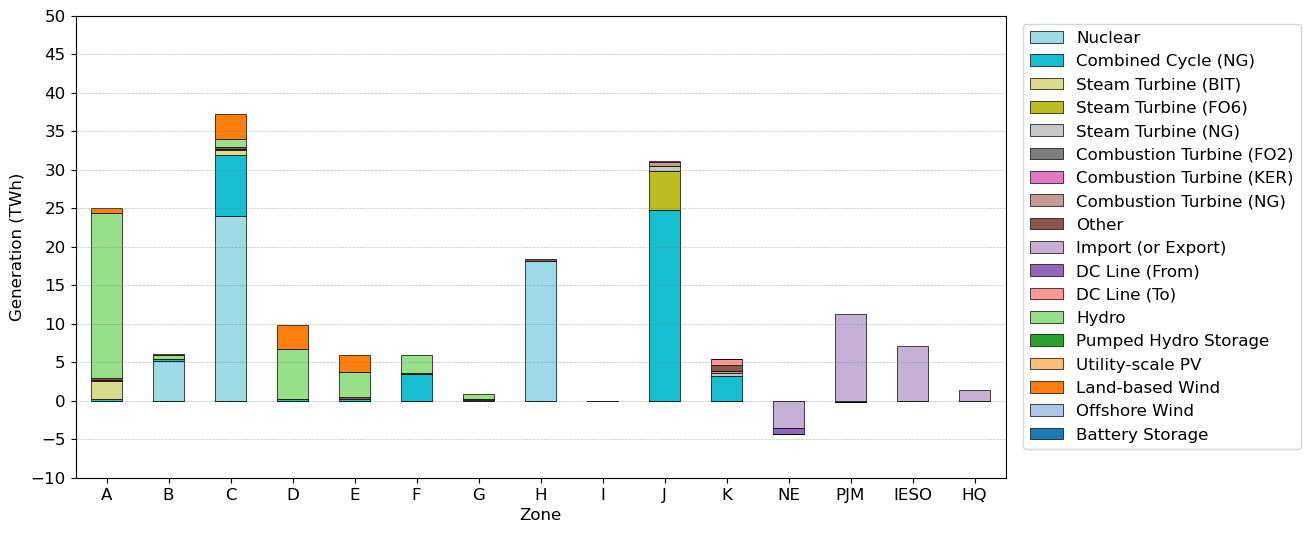

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2018NewParams.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

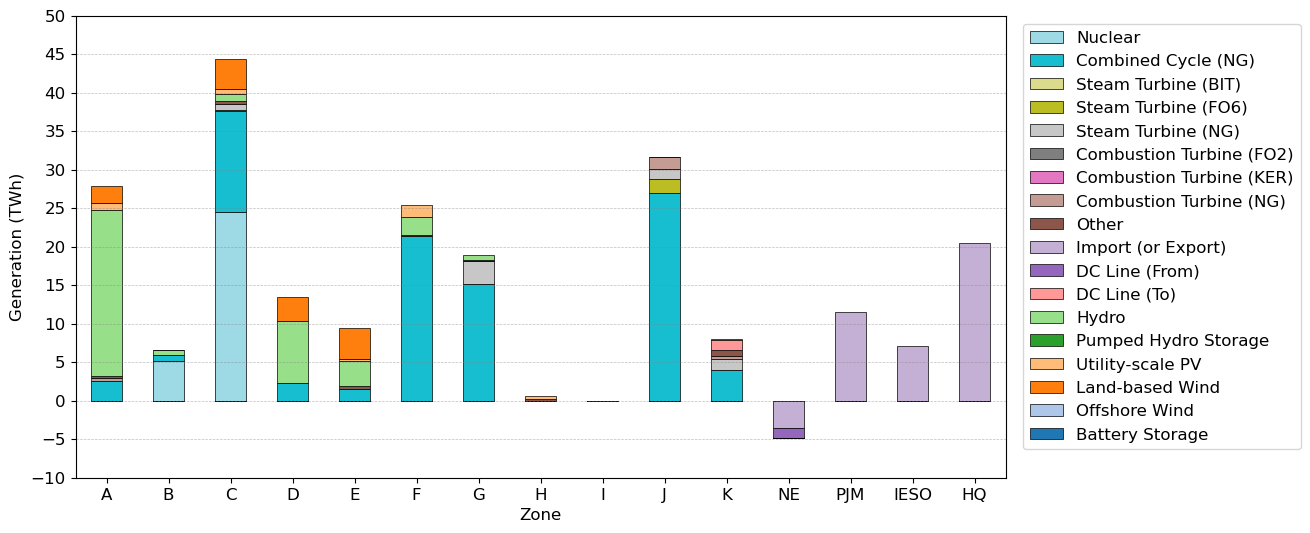

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030BaselineCase.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

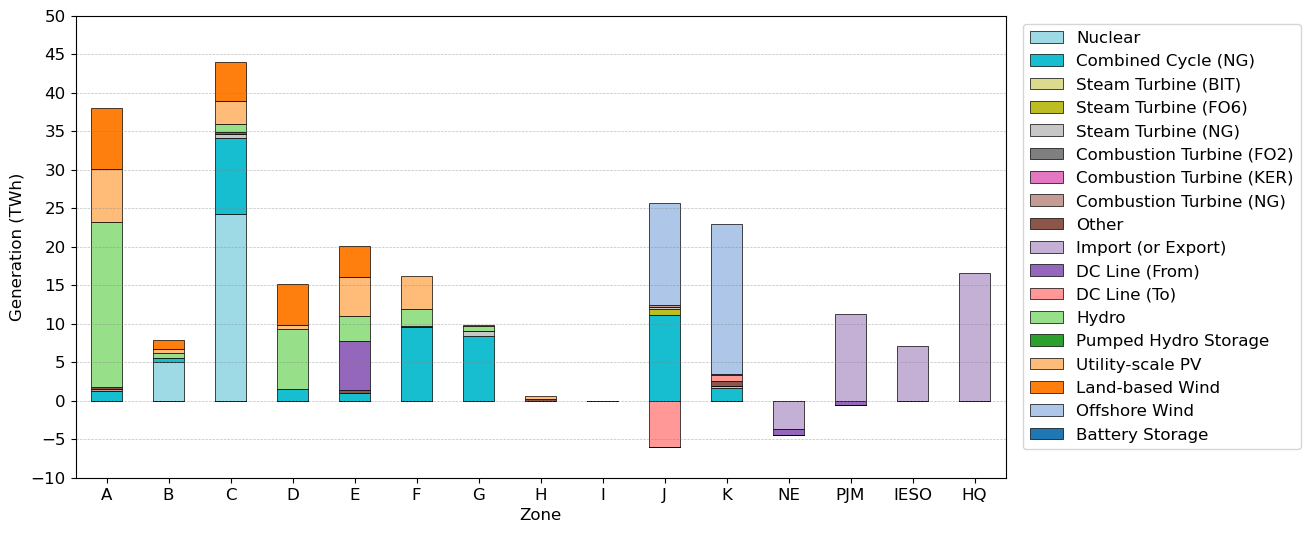

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030ContractCase.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

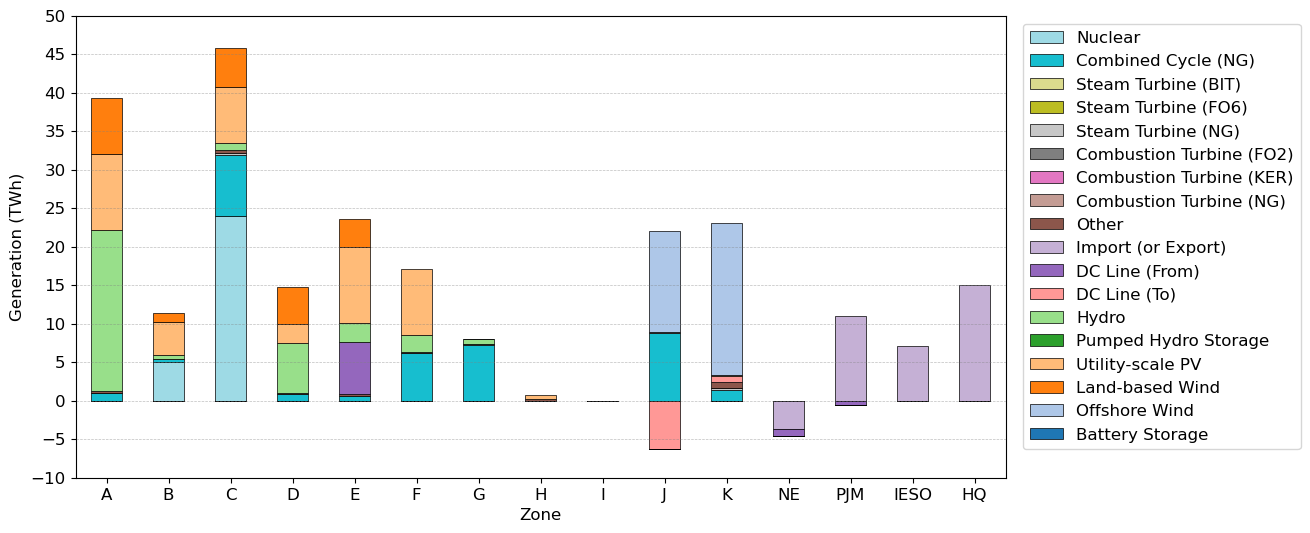

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030StateScenario.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

In [60]:
pg_by_zone_sum_2018NewParams = pg_by_fuel_sum_by_zone_2018NewParams.sum(axis=1)
pg_by_zone_sum_2030BaselineCase = pg_by_fuel_sum_by_zone_2030BaselineCase.sum(axis=1)
pg_by_zone_sum_2030ContractCase = pg_by_fuel_sum_by_zone_2030ContractCase.sum(axis=1)
pg_by_zone_sum_2030StateScenario = pg_by_fuel_sum_by_zone_2030StateScenario.sum(axis=1)

pg_by_zone_sum_summary = pd.DataFrame({
    '2018NewParams': pg_by_zone_sum_2018NewParams,
    '2030BaselineCase': pg_by_zone_sum_2030BaselineCase,
    '2030ContractCase': pg_by_zone_sum_2030ContractCase,
    '2030StateScenario': pg_by_zone_sum_2030StateScenario
})

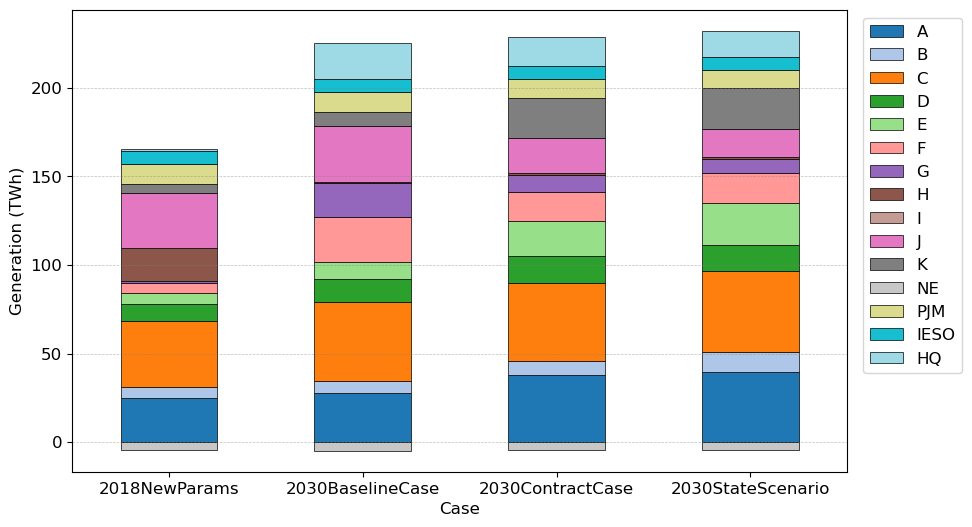

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))
pg_by_zone_sum_summary.T.plot(ax=ax, kind='bar', stacked=True,
                            colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
# ax.set_ylim(-50, 250)
# ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

### 2. Power generation by fuel type by month

In [39]:
pg_by_fuel_sum_by_month_2018NewParams = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2018NewParams,
    gen_fuel_rename)

pg_by_fuel_sum_by_month_2030BaselineCase = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030BaselineCase,
    gen_fuel_rename)

pg_by_fuel_sum_by_month_2030ContractCase = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030ContractCase,
    gen_fuel_rename)

pg_by_fuel_sum_by_month_2030StateScenario = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030StateScenario,
    gen_fuel_rename)

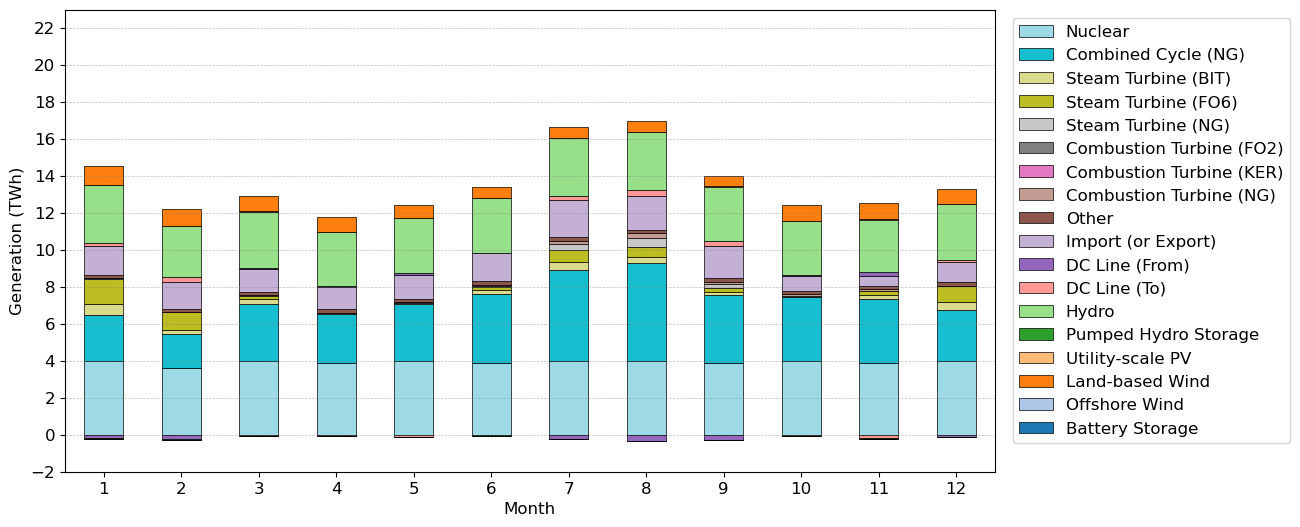

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2018NewParams.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

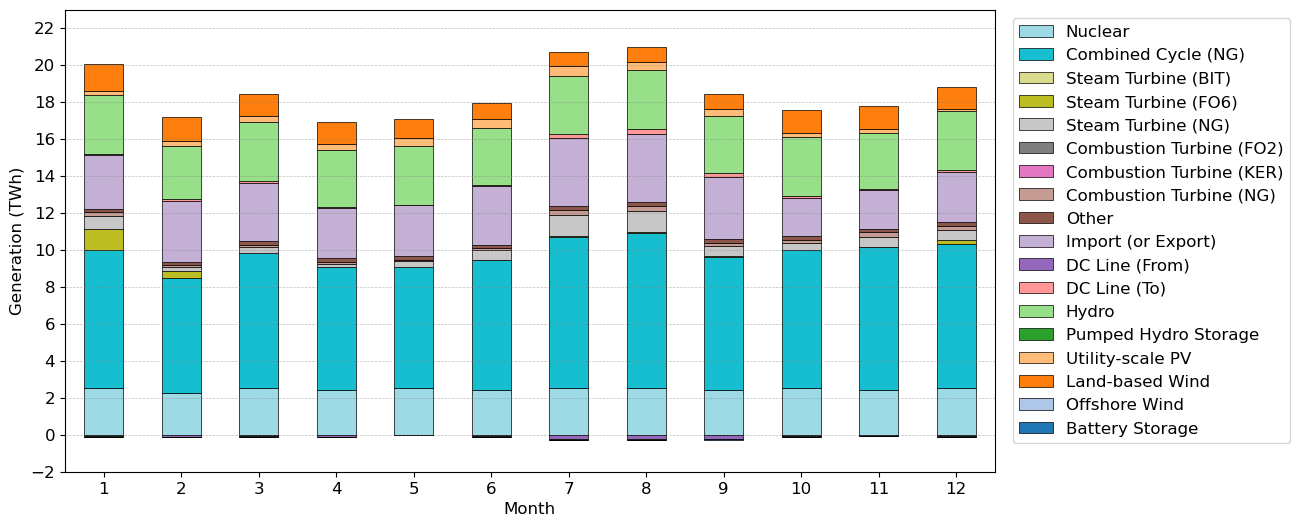

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030BaselineCase.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

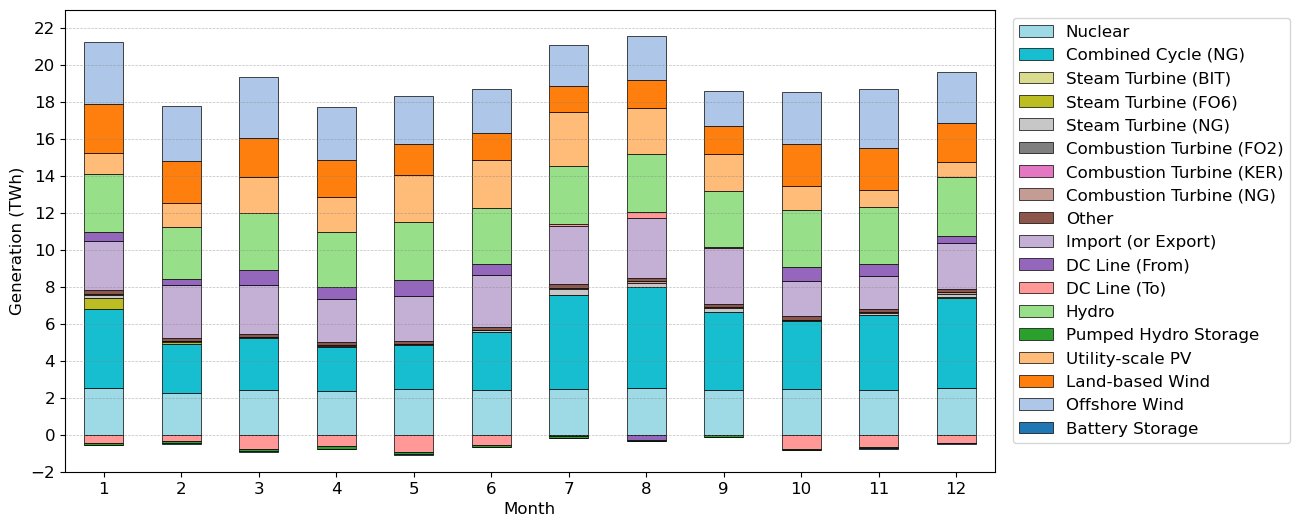

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030ContractCase.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

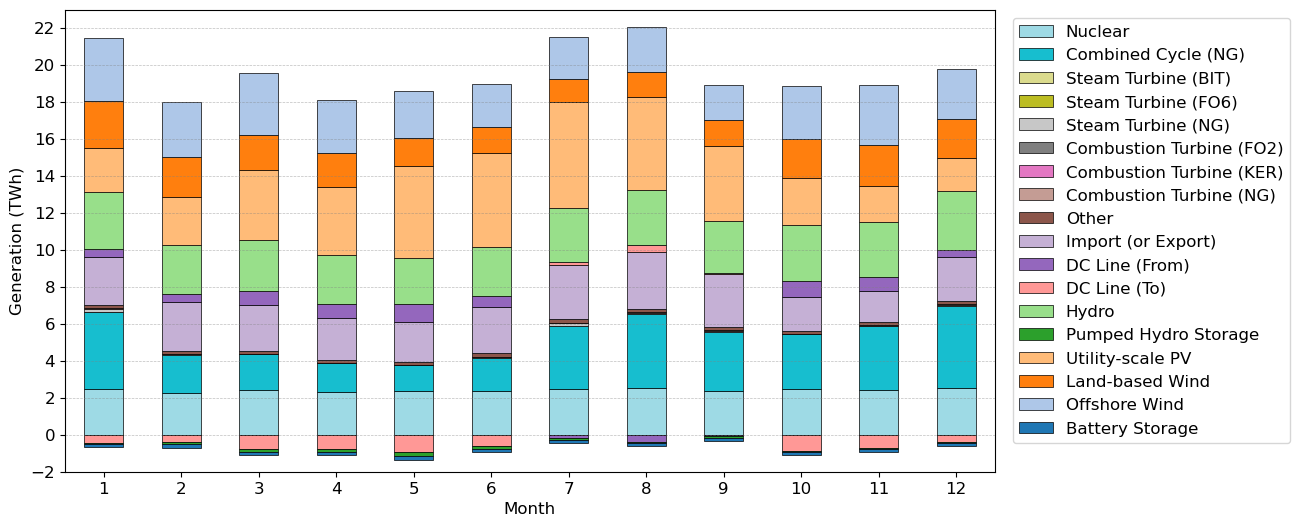

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030StateScenario.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

### 3. Inter-case comparison

In [47]:
pg_by_fuel_sum_2018NewParams = pg_by_fuel_sum_by_month_2018NewParams.sum(axis=0)
pg_by_fuel_sum_2030BaselineCase = pg_by_fuel_sum_by_month_2030BaselineCase.sum(axis=0)
pg_by_fuel_sum_2030ContractCase = pg_by_fuel_sum_by_month_2030ContractCase.sum(axis=0)
pg_by_fuel_sum_2030StateScenario = pg_by_fuel_sum_by_month_2030StateScenario.sum(axis=0)

pg_by_fuel_sum_summary = pd.DataFrame({
    '2018NewParams': pg_by_fuel_sum_2018NewParams,
    '2030BaselineCase': pg_by_fuel_sum_2030BaselineCase,
    '2030ContractCase': pg_by_fuel_sum_2030ContractCase,
    '2030StateScenario': pg_by_fuel_sum_2030StateScenario
})

In [49]:
pg_by_fuel_sum_summary

,2018NewParams,2030BaselineCase,2030ContractCase,2030StateScenario
Nuclear,4.716849e+01,29.598631,2.930861e+01,29.002757
Combined Cycle (NG),4.036670e+01,87.972479,4.493336e+01,34.434070
Steam Turbine (BIT),3.002964e+00,0.000000,0.000000e+00,0.000000
Steam Turbine (FO6),5.112764e+00,1.985147,8.482817e-01,0.000165
Steam Turbine (NG),1.312975e+00,6.557307,1.559485e+00,0.618738
Combustion Turbine (FO2),0.000000e+00,0.000000,0.000000e+00,0.000000
Combustion Turbine (KER),4.941381e-16,0.000000,1.124878e-16,0.000000
Combustion Turbine (NG),8.003970e-01,2.171749,4.829844e-01,0.204148
Other,2.295585e+00,2.296280,2.171196e+00,2.101704
Import (or Export),1.618137e+01,35.553372,3.132598e+01,29.451478


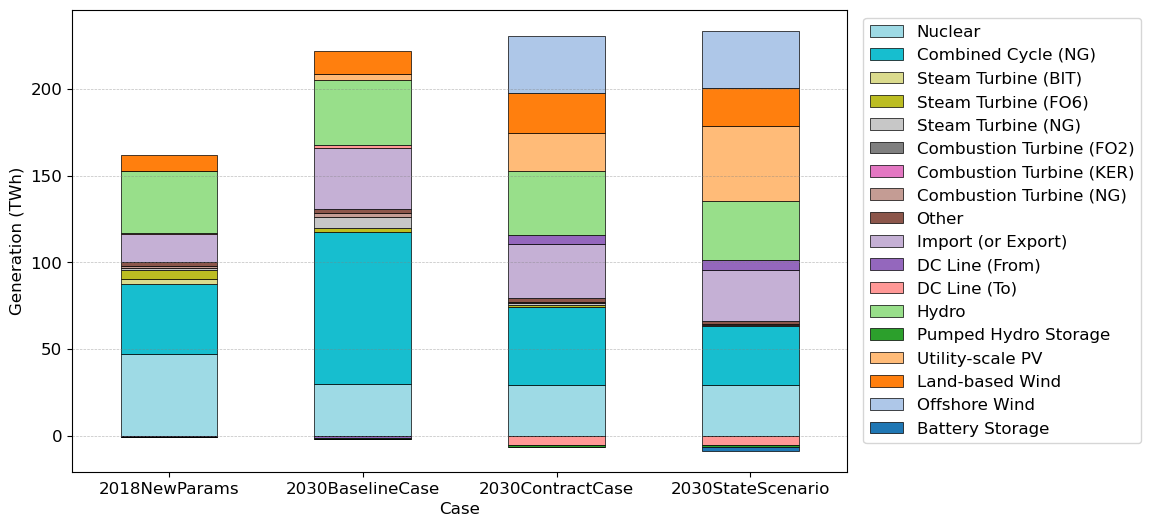

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
pg_by_fuel_sum_summary.T.plot(ax=ax, kind='bar', stacked=True,
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
# ax.set_ylim(-2, 23)
# ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()